Import Library dan Dataset

In [1]:
# Import Library
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, add
from tensorflow.keras.regularizers import l2

In [7]:
# Import Dataset
data_dir = '/content/drive/MyDrive/PMDPM/Dataset Batik'

Data Preprocessing

In [8]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Menyesuaikan ukuran gambar menjadi 224x224
    batch_size=16,  # Mengatur ukuran batch, yaitu 16 data di dalam setiap batch
)

class_names = data.class_names
print(class_names)


# Menghitung jumlah gambar per kelas
hitung_gambar = {}
for file_path in data.file_paths:
    class_name = file_path.split(os.sep)[-2]
    if class_name in hitung_gambar:
        hitung_gambar[class_name] += 1
    else:
        hitung_gambar[class_name] = 1

print("Jumlah gambar dalam setiap kelas:", hitung_gambar)

Found 792 files belonging to 4 classes.
['Batik Celup', 'Batik Kawung', 'Batik Megamendung', 'Batik Parang']
Jumlah gambar dalam setiap kelas: {'Batik Parang': 203, 'Batik Kawung': 195, 'Batik Megamendung': 197, 'Batik Celup': 197}


In [9]:
# Membagi data ke dalam batch
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops.NumpyIterator object at 0x7e2ce9a91680>


In [30]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[3.17500000e+01, 1.60156250e+02, 6.54843750e+01],
         [3.42666016e+01, 1.52549805e+02, 6.54179688e+01],
         [1.32246094e+01, 1.12004883e+02, 3.75214844e+01],
         ...,
         [6.88476562e-01, 2.67226562e+01, 7.21679688e-01],
         [4.49218750e-02, 4.10400391e+01, 4.74316406e+00],
         [1.03281250e+01, 5.92001953e+01, 2.12968750e+01]],

        [[5.72050781e+01, 1.57722656e+02, 4.57763672e+01],
         [6.99921875e+01, 1.71654297e+02, 6.81484375e+01],
         [5.99033203e+01, 1.57181641e+02, 6.76601562e+01],
         ...,
         [1.16210938e+00, 4.22685547e+01, 9.50000000e+00],
         [4.09375000e+00, 5.78027344e+01, 2.14277344e+01],
         [1.14550781e+01, 6.83750000e+01, 3.11025391e+01]],

        [[8.62275391e+01, 1.65101562e+02, 4.58974609e+01],
         [8.99599609e+01, 1.80707031e+02, 6.83417969e+01],
         [4.18183594e+01, 1.42709961e+02, 4.46210938e+01],
         ...,
         [5.45800781e+00, 6.16855469e+01, 2.51708984e+01],
   

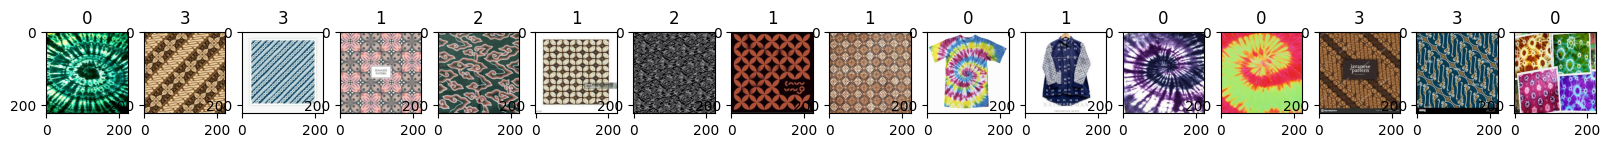

In [31]:
# Display gambar
fig, ax = plt.subplots(ncols=16, figsize=(20,20))
for idx, img in enumerate(batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [32]:
# Normalisasi data
# Memetakan fungsi lambda ke dataset untuk normalisasi data gambar
data = data.map(lambda x, y: (x / 255.0, y))  # Membagi nilai pixel dengan 255 untuk mendapatkan rentang [0,1]
print("Tipe data setelah normalisasi: {}".format(data.element_spec))
print("Bentuk data setelah normalisasi: {}".format(data.element_spec))
print("Jumlah data", len(data))

Tipe data setelah normalisasi: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Bentuk data setelah normalisasi: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 50


In [33]:
# Membagi data untuk training, validasi, dan testing
dataset_size = len(data)
train_size = int(dataset_size * 0.8)  # 80% untuk training
val_size = int(dataset_size * 0.1)    # 10% untuk validasi
test_size = dataset_size - train_size - val_size  # 10% untuk testing

# Membagi dataset
train = data.take(train_size)  # Ambil data untuk training
val = data.skip(train_size).take(val_size)  # Lewatkan data training, ambil data untuk validasi
test = data.skip(train_size + val_size).take(test_size)  # Lewatkan data training dan validasi, ambil sisa untuk testing

# Print ukuran dari masing-masing bagian dataset
print(f"Ukuran training set: {train_size}")
print(f"Ukuran validation set: {val_size}")
print(f"Ukuran test set: {test_size}")

Ukuran training set: 40
Ukuran validation set: 5
Ukuran test set: 5


Pembuatan Model ResNet

In [34]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, l2_reg=0.00001):
    shortcut = x

    # Convolutional shortcut
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding="same",
                          kernel_regularizer=l2(l2_reg))(x)
        shortcut = BatchNormalization()(shortcut)

    # Convolutional Pertama diikuti dengan batch normalization danReLU
    x = Conv2D(filters, kernel_size, strides=stride, padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Convolutional Kedua diikuti dengan batch normalization danReLU
    x = Conv2D(filters, kernel_size, padding="same", use_bias=False, kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    # Shortcut dan output
    x = add([shortcut, x])
    x = ReLU()(x)

    return x

In [35]:
def build_resnet_model(input_shape, jumlah_kelas):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Max pool
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage pertama
    for _ in range(3):
        x = residual_block(x, 64)

    # Stage kedua
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    for _ in range(4):
        x = residual_block(x, 128)

    # Stage ketiga
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    for _ in range(6):
        x = residual_block(x, 256)

    # Stage keempat
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    for _ in range(3):
        x = residual_block(x, 512)

    # Avg piool
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(jumlah_kelas, activation='softmax')(x)

    # Bangun Model
    model = models.Model(inputs, x)
    model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [38]:
# Membangun model build_resnet_model fungsi yang sudah dibuat
resnet_model = build_resnet_model(input_shape=(224, 224, 3), jumlah_kelas = 4)
resnet_model.summary()  # Menampilkan ringkasan model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 112, 112, 64)         9408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_42 (Ba  (None, 112, 112, 64)         256       ['conv2d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_39 (ReLU)             (None, 112, 112, 64)         0         ['batch_normalization_42

Pelatihan (Training) ResNet

In [39]:
# Melatih model dengan 50 epoch
resnet_history = resnet_model.fit(train, epochs=50, validation_data=val)  # Melatih model dengan data training dan validasi

Epoch 1/50
40/40 [==============================] - 39s 516ms/step - loss: 2.3749 - accuracy: 0.3438 - val_loss: 271.5020 - val_accuracy: 0.3125
Epoch 2/50
40/40 [==============================] - 9s 214ms/step - loss: 1.3132 - accuracy: 0.4594 - val_loss: 2.1351 - val_accuracy: 0.3250
Epoch 3/50
40/40 [==============================] - 9s 225ms/step - loss: 1.2132 - accuracy: 0.4344 - val_loss: 1.6829 - val_accuracy: 0.3250
Epoch 4/50
40/40 [==============================] - 8s 198ms/step - loss: 1.1545 - accuracy: 0.5188 - val_loss: 1.4723 - val_accuracy: 0.2875
Epoch 5/50
40/40 [==============================] - 9s 217ms/step - loss: 1.1330 - accuracy: 0.5250 - val_loss: 1.6495 - val_accuracy: 0.3625
Epoch 6/50
40/40 [==============================] - 11s 263ms/step - loss: 1.1475 - accuracy: 0.5094 - val_loss: 1.3466 - val_accuracy: 0.4375
Epoch 7/50
40/40 [==============================] - 9s 213ms/step - loss: 1.1804 - accuracy: 0.5422 - val_loss: 1.3514 - val_accuracy: 0.4500
Ep

Evaluasi Model

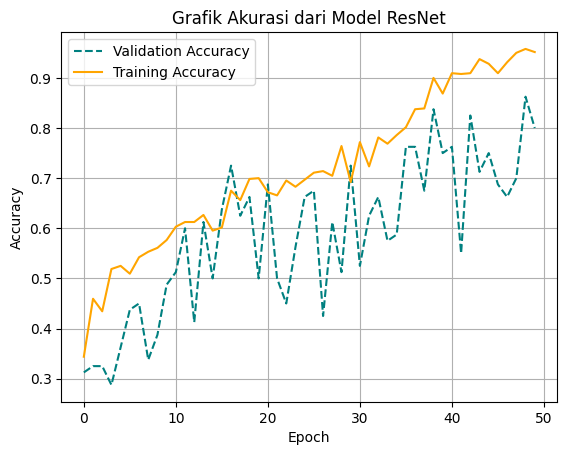

In [40]:
# Membuat grafik visualisasi untuk Akurasi model Alexnet
fig, ax1 = plt.subplots()
ax1.plot(resnet_history.history['val_accuracy'], color='teal', linestyle='--', label='Validation Accuracy')
ax1.plot(resnet_history.history['accuracy'], color='orange', linestyle='-', label='Training Accuracy')
ax1.set_title('Grafik Akurasi dari Model ResNet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="upper left")
ax1.grid(True)

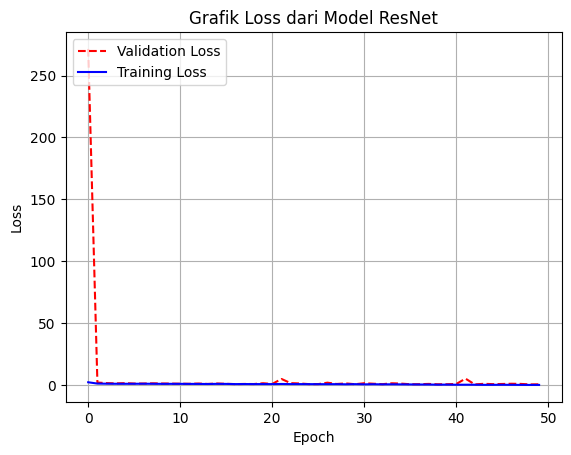

In [41]:
# Membuat grafik visualisasi untuk Loss model Alexnet
fig, ax2 = plt.subplots()
ax2.plot(resnet_history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
ax2.plot(resnet_history.history['loss'], color='blue', linestyle='-', label='Training Loss')
ax2.set_title('Grafik Loss dari Model ResNet')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc="upper left")
ax2.grid(True)

In [51]:
# Evaluasi model menggunakan data tes
test_loss, test_accuracy = resnet_model.evaluate(test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

5/5 [==============================] - 3s 48ms/step - loss: 0.8166 - accuracy: 0.8194
Test Loss: 0.8165923357009888
Test Accuracy: 0.8194444179534912


In [52]:
# Eksport model yang sudah jadi
resnet_model.save('/content/drive/MyDrive/PMDPM/Model/Proyek UAS_A_Salam BE_ResNET CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
